In [8]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

O Dataset escolhido foi o dataset referente ao Preço das ações da Apple de 1980 a 2021, este dataset pode ser acessado [aqui](https://www.kaggle.com/datasets/meetnagadia/apple-stock-price-from-19802021/code). endo um dataset que já é indicado a sua execução de análise de séries Temporais e EDA.


In [18]:
# Carregando a base de dados da Apple
df = pd.read_csv('/content/drive/My Drive/Ponderada/AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


## Descrição das colunas do dataset

Abaixo é possível saber o significado de cada coluna:


* **Date (Data) - Data da observação**:
   * Tipo: datetime.
   * Representa a data em que os dados de preço de ação foram registrados. Algo importante para identificar a ordem cronológica dos dados (essencial na análse de séries temporais).
* **Open (open) - Preço de abertura da ação naquele dia**:
  * Tipo: float.
  * É o preço pelo qual a ação da Apple começou a ser negociada no início do dia de mercado. Esse valor pode ser diferente do preço de fechamento do dia anterior devido a diversos fatores como notícias ou mudanças no mercado durante o dia/noite.
* **High (Máxima) - Maior preço da ação naquele dia**:
  * Tipo: float.
  * É o maior preço que a ação alcançou durante o dia. Esse valor é útil para entender o teto de negociação dentro de um único dia e pode indicar o limite de interesse dos investidores.
* **Low (Mínima) - Menor preço da ação naquele dia**:
  * Tipo: float.
  * É o menor preço que a ação atingiu durante o dia. Ao contrário do preço máximo, o Low significa o preço mais baixo que os investidores estavam dispostos a pagar durante esse período.
* **Close (Fechamento) - Preço de fechamento da ação naquele dia**:
  * Tipo: float
  * É o preço de fechamento da ação no final do dia de negociação. Este é pode ser considerado o valor mais importante, pois é o preço final pelo qual a ação foi negociada naquele dia. Com essa coluna, é possível prever preços futuros ao usar análise de séries temporais.
* **Adj Close (Fechamento ajustado)** - Preço de fechamento ajustado
  * Tipo: float.
  * É o preço de fechamento ajustado para eventos corporativos, como dividendos, desdobramentos de ações (splits) e outras ações corporativas. Esse ajuste permite uma comparação mais precisa ao longo do tempo, considerando as mudanças estruturais na ação.
* **Volume (Volume) - Número de ações negociadas naquele dia**:
  * Tipo: int.
  * É o número total de ações negociadas durante o dia. O volume pode indicar o nível de interesse e liquidez em relação à ação, com volumes mais altos, maior é o interesse de compra e venda.



## Aplicação das colunas

Esta seção é uma pequena expicação referente a modelagem e predição de séries temporais com cada coluna que já foi descrita anteriormente.

* **Coluna Date**: ajuda a organizar os dados de forma cronológica.
* **Coluna Close ou Adj Close**: são usadas como a variável alvo em modelos de predição de preços, pois representam o valor final de negociação de uma ação em um dia específico.
* **Coluna Open, High, Low, e Volume**: podem ser usadas como características (features) adicionais para melhorar as predições, fornecendo um contexto mais completo sobre as condições de mercado em cada dia.

## Escolha da métrica (MSE)

A métrica escolhida foi o MSE (Mean Squared Error) por se tratar de uma tarefa de predição de valores numéricos contínuos (preço de ações). O MSE é usado para verificar a acurácia de modelos e dá um maior peso aos maiores erros, já que, ao ser calculado, cada erro é elevado ao quadrado individualmente e, após isso, a média desses erros quadráticos é calculada - [Alura](https://www.alura.com.br/artigos/metricas-de-avaliacao-para-series-temporais?srsltid=AfmBOoqcGHB6zzoVCptRfYB1ZI_8HCfRAQge_k7ZryzbgyqyuZwAG92u).

Então, medindo a média dos quadrados dos erros entre os valores preditos e os valores reais, há mais penalização nos erros maiores. O que o torna adequado para problemas de regressão como esse e que utiliza-se para a previsão de preços de ações na bolsa de valores, o qual envolve além do MSE, o MAE também
 ([Previsão de Preços de Ações com Modelos de Regressão e Séries Temporais](https://www.linkedin.com/pulse/previs%C3%A3o-de-pre%C3%A7os-a%C3%A7%C3%B5es-com-modelos-regress%C3%A3o-e-s%C3%A9ries-howard-roatti/)).

## Implementação do modelo de predição usando RNN

### Pré-Processamento

In [19]:
# Preprocessamento de dados
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Seleciona a coluna Close para a predição
data = df[['Close']].values

# Escala os dados para o intervalo (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Função para criar a estrutura de série temporal
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Número de timestamps
time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reformulação dos dados para o formato [samples, time steps, features] de LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Separação dos dados em treino e teste (67% para treino)
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

### Modelo

In [20]:
# Modelo RNN LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Aplicação do Mean Squared Error(MSE) como loss
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# Predicão do teste
y_pred = model.predict(X_test)

# Transformação inversa dos dados reais e preditos
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.3046e-05 - val_loss: 0.0093
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6119e-07 - val_loss: 0.0081
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.6346e-07 - val_loss: 0.0065
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.4810e-07 - val_loss: 0.0063
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.4036e-07 - val_loss: 0.0058
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.7586e-07 - val_loss: 0.0047
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.2937e-07 - val_loss: 0.0037
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.1304e-07 - val_loss: 0.0056
Epoch 9/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.8576e-07 - val_loss: 0.0033
Epoch 10/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.1917e-07 - val_loss: 0.0031
Epoch 11/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.9216e-07 - val_loss: 0.0033
Epoch 12/50
218/21

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Resultados

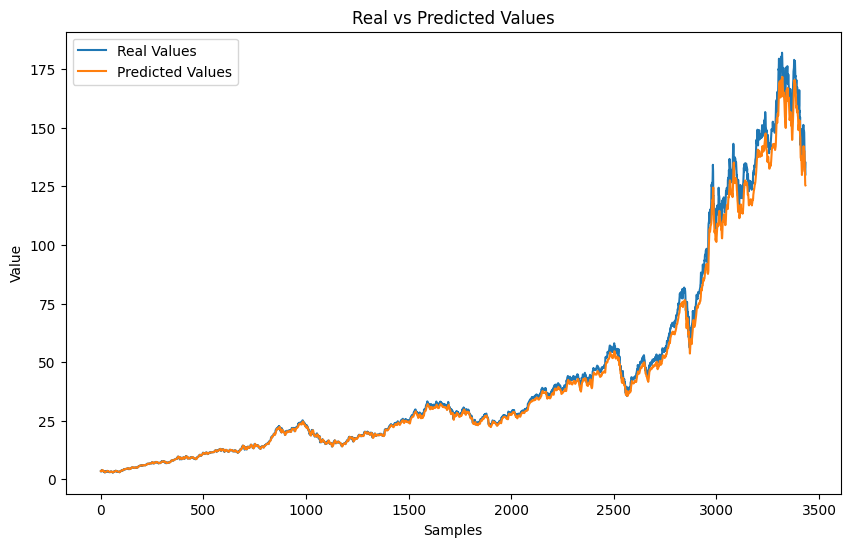

In [21]:
# Plot dos valores reais vs preditos
plt.figure(figsize=(10,6))
plt.plot(y_test_inverse, label='Real Values')
plt.plot(y_pred_inverse, label='Predicted Values')
plt.title('Real vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()

#### Análise do resultado (Conclusão)

O modelo consegue capturar bem a tendência geral dos dados das ações da Apple ao longo dos anos. Os valores preditos se identificam na cor laranja e acompanham bem a curva dos valores reais(azul), o que indica que o modelo está aprendendo a dinâmica temporal dos dados, mesmo que em alguns momentos apresente dificuldade de capturar picos e vales. Além disso, com o MSE aparentemente está penalização os erros quando o valor valor predito está distante do valor real.